In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

2024-04-08 05:13:55.520392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 05:13:55.520527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 05:13:55.654006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [37]:
import pandas as pd

# Read data from the specific sheet named "modified_data"
df_org = pd.read_excel("/kaggle/input/testing21/DatasetForGita.xlsx", sheet_name="modified_data")

# Shuffle the data
df_org = df_org.sample(frac=1.0, random_state=42)

# Display the first few rows of the DataFrame
print(df_org.head())

                                                   Text     Emotion  \
507   দ্রোণ, ভীষ্ম, জয়দ্রথ এবং কর্ণ, যেমন অন্যান্য ...  Optimistic   
2598  মনে রেখো যে আলো, সূর্য থেকে নির্গত হয়ে সমস্ত ...  Idealistic   
2348  আমার উপর তোমার মন স্থির কর, আমার জন্য নিজেকে উ...        Love   
1786    শোন, এবং আমি তোমাকে তাদের পার্থক্য ব্যাখ্যা করব  Idealistic   
949   ইন্দ্রিয়গুলিকে একইভাবে সংযুক্তি এবং বিদ্বেষ থ...  Optimistic   

     label_column score_column  
507           NaN          NaN  
2598          NaN          NaN  
2348          NaN          NaN  
1786   Optimistic     0.856038  
949           NaN          NaN  


In [41]:
import pandas as pd

# Read data from the "modified_data" sheet
df_modified = pd.read_excel("/kaggle/input/testing21/DatasetForGita.xlsx", sheet_name="modified_data")

# Read data from the "25K" sheet
df_25k = pd.read_excel("/kaggle/input/testing21/DatasetForGita.xlsx", sheet_name="25K")

# Shuffle the data in both dataframes
df_modified = df_modified.sample(frac=1.0, random_state=42)
df_25k = df_25k.sample(frac=1.0, random_state=42)

# Merge both dataframes
df_org = pd.concat([df_modified, df_25k], ignore_index=True)

# Display the first few rows of the merged DataFrame
print(df_org.head())

                                                Text     Emotion label_column  \
0  দ্রোণ, ভীষ্ম, জয়দ্রথ এবং কর্ণ, যেমন অন্যান্য ...  Optimistic          NaN   
1  মনে রেখো যে আলো, সূর্য থেকে নির্গত হয়ে সমস্ত ...  Idealistic          NaN   
2  আমার উপর তোমার মন স্থির কর, আমার জন্য নিজেকে উ...        Love          NaN   
3    শোন, এবং আমি তোমাকে তাদের পার্থক্য ব্যাখ্যা করব  Idealistic   Optimistic   
4  ইন্দ্রিয়গুলিকে একইভাবে সংযুক্তি এবং বিদ্বেষ থ...  Optimistic          NaN   

  score_column  
0          NaN  
1          NaN  
2          NaN  
3     0.856038  
4          NaN  


In [42]:
labels = df_org['Emotion'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Optimistic',
 'Idealistic',
 'Love',
 'Sadness',
 'Surprise',
 'Annoyed',
 'Anxious',
 'Optimistic']

In [43]:
for key, value in enumerate(labels):
    print(value)

Optimistic
Idealistic
Love
Sadness
Surprise
Annoyed
Anxious
Optimistic


In [44]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [45]:
label2id

{'Optimistic': 7,
 'Idealistic': 1,
 'Love': 2,
 'Sadness': 3,
 'Surprise': 4,
 'Annoyed': 5,
 'Anxious': 6}

In [46]:
id2label

{0: 'Optimistic',
 1: 'Idealistic',
 2: 'Love',
 3: 'Sadness',
 4: 'Surprise',
 5: 'Annoyed',
 6: 'Anxious',
 7: 'Optimistic'}

In [47]:
df_org.head()

,Text,Emotion,label_column,score_column
0,"দ্রোণ, ভীষ্ম, জয়দ্রথ এবং কর্ণ, যেমন অন্যান্য ...",Optimistic,NaN,NaN
1,"মনে রেখো যে আলো, সূর্য থেকে নির্গত হয়ে সমস্ত ...",Idealistic,NaN,NaN
2,"আমার উপর তোমার মন স্থির কর, আমার জন্য নিজেকে উ...",Love,NaN,NaN
3,"শোন, এবং আমি তোমাকে তাদের পার্থক্য ব্যাখ্যা করব",Idealistic,Optimistic,0.856038
4,ইন্দ্রিয়গুলিকে একইভাবে সংযুক্তি এবং বিদ্বেষ থ...,Optimistic,NaN,NaN


In [48]:
df_org["labels"]=df_org.Emotion.map(lambda x: label2id[x.strip()])

In [49]:
df_org.head(30)

,Text,Emotion,label_column,score_column,labels
0,"দ্রোণ, ভীষ্ম, জয়দ্রথ এবং কর্ণ, যেমন অন্যান্য ...",Optimistic,NaN,NaN,7
1,"মনে রেখো যে আলো, সূর্য থেকে নির্গত হয়ে সমস্ত ...",Idealistic,NaN,NaN,1
2,"আমার উপর তোমার মন স্থির কর, আমার জন্য নিজেকে উ...",Love,NaN,NaN,2
3,"শোন, এবং আমি তোমাকে তাদের পার্থক্য ব্যাখ্যা করব",Idealistic,Optimistic,0.856038,1
4,ইন্দ্রিয়গুলিকে একইভাবে সংযুক্তি এবং বিদ্বেষ থ...,Optimistic,NaN,NaN,7
5,"জেনে রেখ যে, সত্ত্ব, রজস ও তমস এই তিনটি গুণের ...",Idealistic,NaN,NaN,1
6,"কিন্তু অজ্ঞ, সিদ্ধান্তহীন এবং বিশ্বাসের অভাব ত...",Sadness,NaN,NaN,3
7,"দেবতা, দেবতা, দানব সকলেই তোমাকে দেখে অভিভূত",Surprise,Love,0.98816,4
8,তারপরে তার প্রাক্তন জীবনে অর্জিত অভিজ্ঞতা পুনর...,Idealistic,Love,0.662123,1
9,দেবতা বা মহান দ্রষ্টা কেউই আমার আদি সম্পর্কে জ...,Idealistic,NaN,NaN,1


<Axes: ylabel='count'>

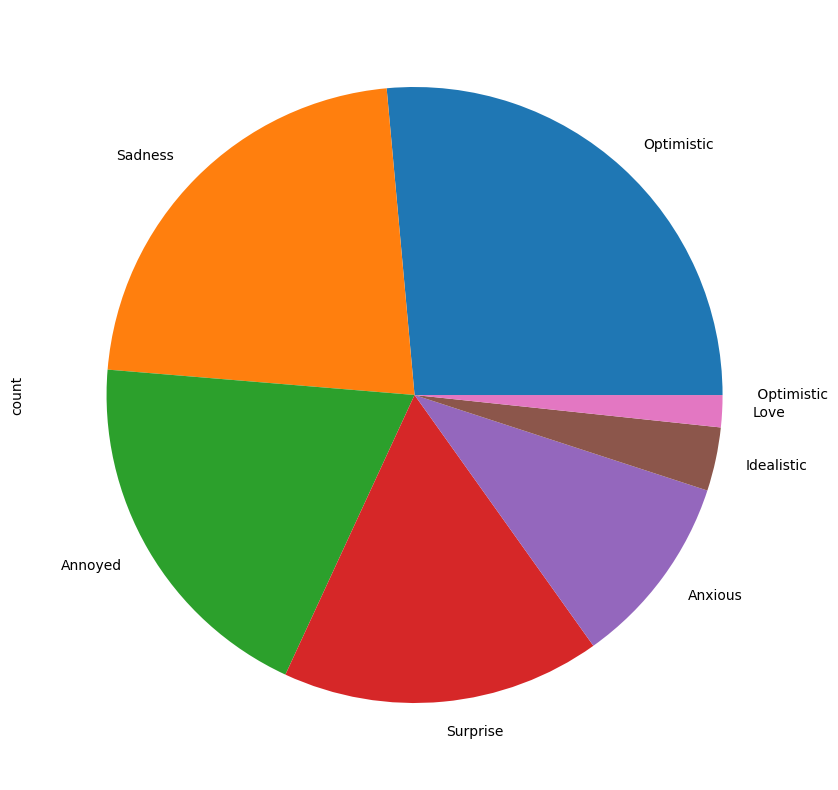

In [50]:
df_org.Emotion	.value_counts().plot(kind='pie', figsize=(10,10))

In [51]:
tokenizer = BertTokenizerFast.from_pretrained("sagorsarker/bangla-bert-base", max_length=512)

In [52]:
model = BertForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [53]:
SIZE= df_org.shape[0]

train_texts= list(df_org.Text[:SIZE//2])

val_texts=   list(df_org.Text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.Text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [54]:
len(train_texts)

14572

In [55]:
len(train_texts), len(val_texts), len(test_texts)

(14572, 7286, 7286)

In [56]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [57]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [58]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [59]:
from transformers import TrainingArguments, Trainer

In [60]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [61]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='/kaggle/working/TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=6,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./kaggle/working/multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [62]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [63]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.868300,1.533835,0.396651,0.324715,0.356746,0.353834
100,1.592300,1.426629,0.436728,0.314754,0.347541,0.320337
150,1.500000,1.309138,0.494373,0.293635,0.300237,0.321852
200,1.372500,1.278517,0.519215,0.366025,0.539981,0.384995
250,1.297200,1.226785,0.542136,0.423498,0.512613,0.411627
300,1.246900,1.074698,0.604996,0.473890,0.515444,0.468833
350,1.247000,1.043570,0.610074,0.483222,0.523062,0.476463
400,1.138700,1.041950,0.613505,0.495888,0.538458,0.487716
450,1.174100,1.019755,0.631211,0.431415,0.454492,0.426516
500,1.092400,1.009432,0.648778,0.533603,0.547287,0.525941


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

TrainOutput(global_step=5466, training_loss=0.496060209748861, metrics={'train_runtime': 7981.6312, 'train_samples_per_second': 10.954, 'train_steps_per_second': 0.685, 'total_flos': 1.5097402078230528e+16, 'train_loss': 0.496060209748861, 'epoch': 6.0})

In [64]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.535616,0.817184,0.764250,0.820496,0.754744
val,0.776093,0.727971,0.598734,0.605428,0.595250
test,0.744707,0.741285,0.609603,0.614504,0.606745


In [74]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [75]:
# Test with a an example text in Turkish
text = "আমার ব্যথাগুলো আমারই থাক অশ্রুতে দুটি চোখ যায় ভরে যাক।"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [76]:
model_path = "/kaggle/working/verse-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/kaggle/working/verse-text-classification-model/tokenizer_config.json',
 '/kaggle/working/verse-text-classification-model/special_tokens_map.json',
 '/kaggle/working/verse-text-classification-model/vocab.txt',
 '/kaggle/working/verse-text-classification-model/added_tokens.json',
 '/kaggle/working/verse-text-classification-model/tokenizer.json')

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


In [77]:
model_path = "/kaggle/working/verse-text-classification-model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [96]:
nlp("এবং বিচিত্র অভিলাষে আছড়ে পড়ে, ভ্রান্তির জালে আটকে, ক্ষুধার্তের গভীরে আটকে, নোংরা নরকে পতিত হয়")

[{'label': 'Annoyed', 'score': 0.6571110486984253}]

In [38]:
import pandas as pd

# Load the Excel file into a DataFrame
df = pd.read_csv("/kaggle/input/donebaba/DatasetForGita - Label2.csv")

# Iterate over each row
for index, row in df.iterrows():
    # Get the text from the desired column (change 'text_column' to the name of the column containing text)
    text = row['Text']
    
    # Perform sentiment analysis
    result = nlp(text)
    
    # Extract sentiment label and score
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    
    # Set sentiment label and score in new columns (change 'label_column' and 'score_column' to desired column names)
    df.at[index, 'label_column'] = sentiment_label
    df.at[index, 'score_column'] = sentiment_score

# Save the DataFrame with sentiment analysis results to a new Excel file
df.to_excel("output_with_sentiment_analysis.xlsx", index=False)


In [ ]:
!zip -r file.zip /kaggle/working/verse-text-classification-model

In [ ]:

!cd /kaggle/working

In [ ]:
!tar -czvf my_work.zip -C . .